# Financial Fraud Detection
### Problem Statement
Financial institutions need to detect fraudulent transactions in real-time. Your goal is
to build a robust fraud detection model using historical transactional data and machine
learning classification techniques.

## Reading and Understanding the Data

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

# Set random seed and plotting style
np.random.seed(42)
%matplotlib inline
sns.set_style('whitegrid')

In [4]:
df = pd.DataFrame(pd.read_csv("archive/Synthetic_Financial_datasets_log.csv"))
# Standardize transaction types to use hyphens
type_mapping = {
    'CASH_IN': 'CASH-IN',
    'CASH_OUT': 'CASH-OUT',
    'CASH-IN': 'CASH-IN',
    'CASH-OUT': 'CASH-OUT',
    'DEBIT': 'DEBIT',
    'PAYMENT': 'PAYMENT',
    'TRANSFER': 'TRANSFER'
}
df['type'] = df['type'].map(type_mapping)
if df['type'].isnull().any():
    print("Warning: Some transaction types could not be mapped. Unmapped types:", df[df['type'].isnull()]['type'].unique())
    df = df.dropna(subset=['type'])  # Drop rows with unmapped types

# Verify columns
expected_cols = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
if list(df.columns) != expected_cols:
    print("Warning: Column mismatch. Expected:", expected_cols, "Found:", list(df.columns))
    missing_cols = [col for col in expected_cols if col not in df.columns]
    if missing_cols:
        print("Missing columns:", missing_cols)
        raise KeyError(f"Missing required columns: {missing_cols}")

# Display first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH-OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Inspection

In [6]:
df.shape


(6362620, 11)

In [7]:
df.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# Exploratory Data Analysis (EDA)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


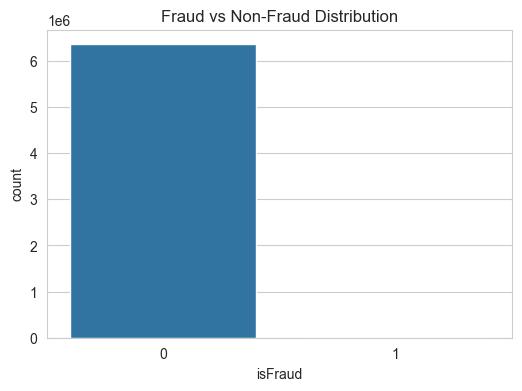


Fraud Proportion:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


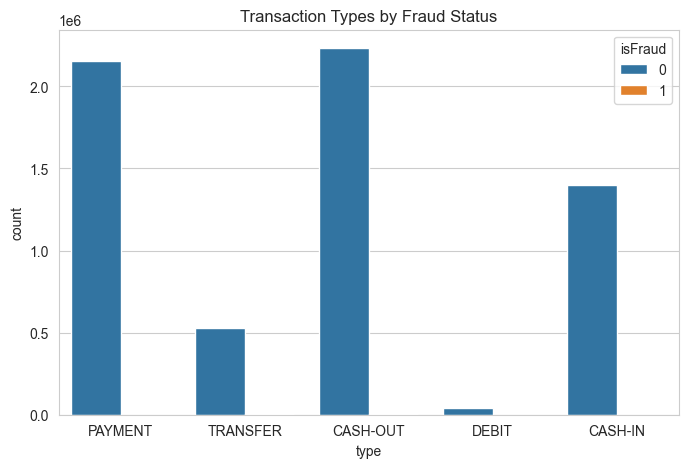

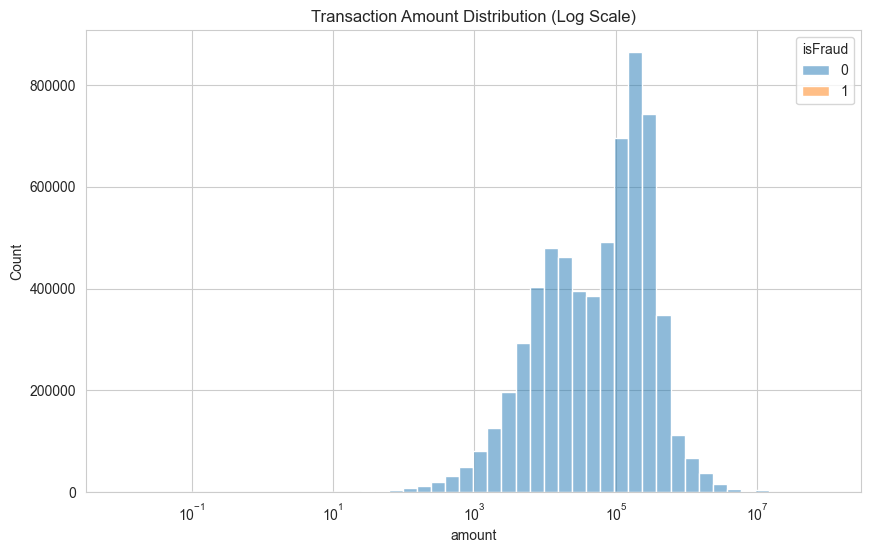

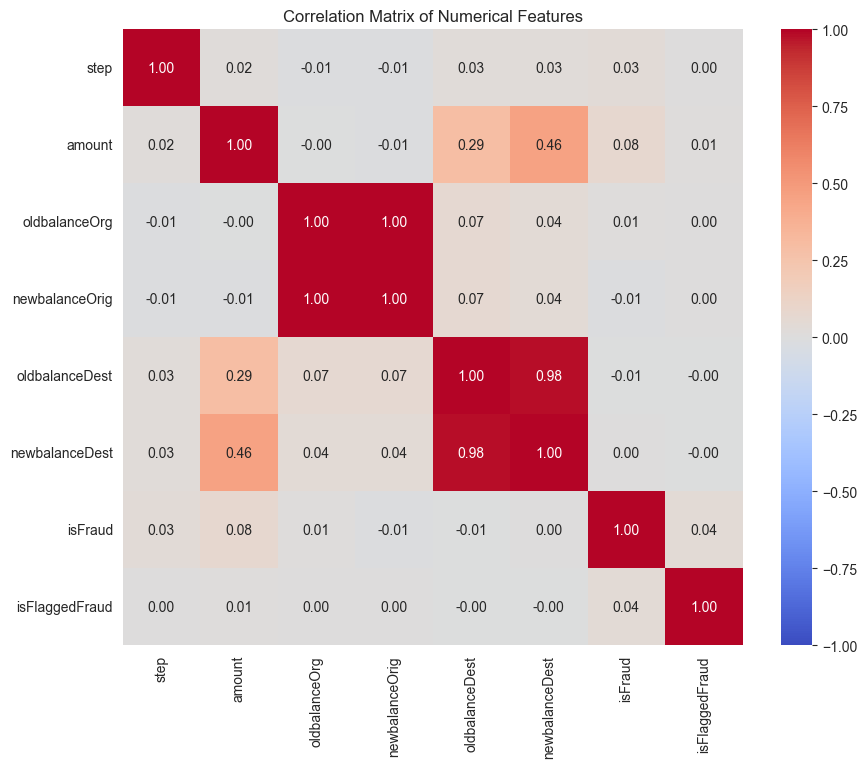

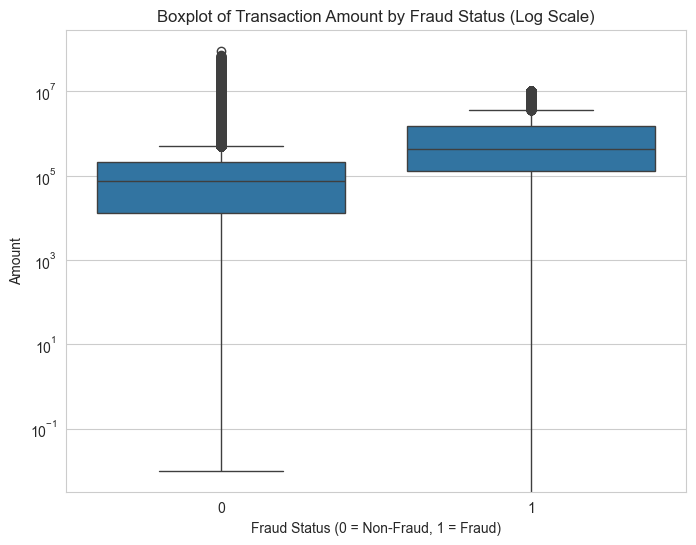

In [10]:
# Exploratory Data Analysis (EDA)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Fraud distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()
print("\nFraud Proportion:")
print(df['isFraud'].value_counts(normalize=True))

# Transaction type distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Types by Fraud Status')
plt.show()

# Amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='isFraud', log_scale=True, bins=50)
plt.title('Transaction Amount Distribution (Log Scale)')
plt.show()

# Correlation matrix for numerical features
numerical_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Boxplot for amount by fraud status
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')  # Use log scale due to skewed distribution
plt.title('Boxplot of Transaction Amount by Fraud Status (Log Scale)')
plt.xlabel('Fraud Status (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Amount')
plt.show()

In [11]:
# Feature Engineering
# Time-based features
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int)

# Amount-based features
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1e-6)  # Avoid division by zero

# Behavior-based features
df['is_merchant'] = df['nameDest'].str.startswith('M').astype(int)
le = LabelEncoder()
# Fit LabelEncoder on standardized transaction types
all_types = ['CASH-IN', 'CASH-OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
le_type = le.fit(all_types)  # Ensure all types are encoded
df['type_encoded'] = le_type.transform(df['type'])

# Transaction frequency (simulated as count per customer)
df['orig_txn_count'] = df.groupby('nameOrig')['step'].transform('count')

# Display first few rows with new features
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,is_night,balance_diff_orig,balance_diff_dest,amount_to_balance_ratio,is_merchant,type_encoded,orig_txn_count
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,1,9839.64,0.0,0.057834,1,3,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,1,1864.28,0.0,0.087735,1,3,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,1,181.00,0.0,1.000000,0,4,1
3,1,CASH-OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,1,181.00,-21182.0,1.000000,0,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,1,11668.14,0.0,0.280795,1,3,1


In [12]:
# Prepare features
features = [
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest',
    'balance_diff_orig',
    'balance_diff_dest',
    'amount_to_balance_ratio',
    'hour',
    'day',
    'is_night',
    'type_encoded',
    'is_merchant',
    'orig_txn_count'
]
X = df[features]
y = df['isFraud']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Results for Logistic Regression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.95      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.52      0.96      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

Confusion Matrix:
[[1220937   49944]
 [     78    1565]]
Precision-Recall AUC: 0.6194
ROC AUC: 0.9918
 Accuracy: 0.9607


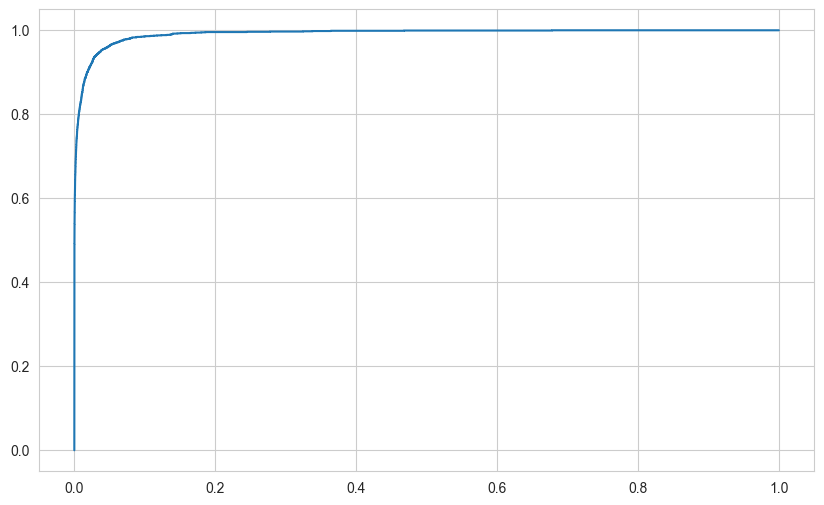

In [13]:
# Train and evaluate models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plot ROC curves for all models
plt.figure(figsize=(10, 6))

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]
print("\nResults for Logistic Regression:")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
pr_auc_lr = auc(recall_lr, precision_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Precision-Recall AUC: {pr_auc_lr:.4f}")
print(f"ROC AUC: {roc_auc_lr:.4f}")
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f" Accuracy: {accuracy_lr:.4f}")
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')


Results for Decision Tree:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.74      0.94      0.82      1643

    accuracy                           1.00   1272524
   macro avg       0.87      0.97      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1270327     554]
 [    103    1540]]
Precision-Recall AUC: 0.8364
ROC AUC: 0.9684
 Accuracy: 0.9995


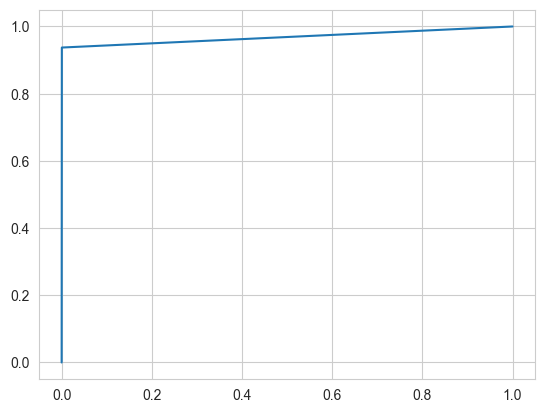

In [14]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]
print("\nResults for Decision Tree:")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
pr_auc_dt = auc(recall_dt, precision_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"Precision-Recall AUC: {pr_auc_dt:.4f}")
print(f"ROC AUC: {roc_auc_dt:.4f}")
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f" Accuracy: {accuracy_dt:.4f}")
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')


Results for XGBoost:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.48      0.98      0.65      1643

    accuracy                           1.00   1272524
   macro avg       0.74      0.99      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1269152    1729]
 [     30    1613]]
Precision-Recall AUC: 0.9695
ROC AUC: 0.9994
Test Accuracy: 0.9986


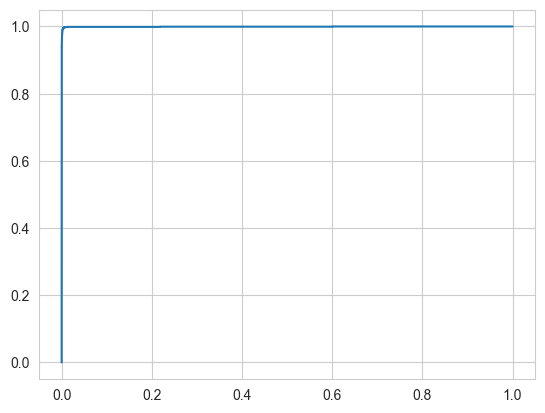

In [15]:
# XGBoost
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("\nResults for XGBoost:")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"Precision-Recall AUC: {pr_auc_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Test Accuracy: {accuracy_xgb:.4f}")
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

Tuned XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.43      0.90      0.58      1643

    accuracy                           1.00   1272524
   macro avg       0.72      0.95      0.79   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1268918    1963]
 [    158    1485]]
Precision-Recall AUC: 0.8819
ROC AUC: 0.9975
Test Accuracy: 0.9983


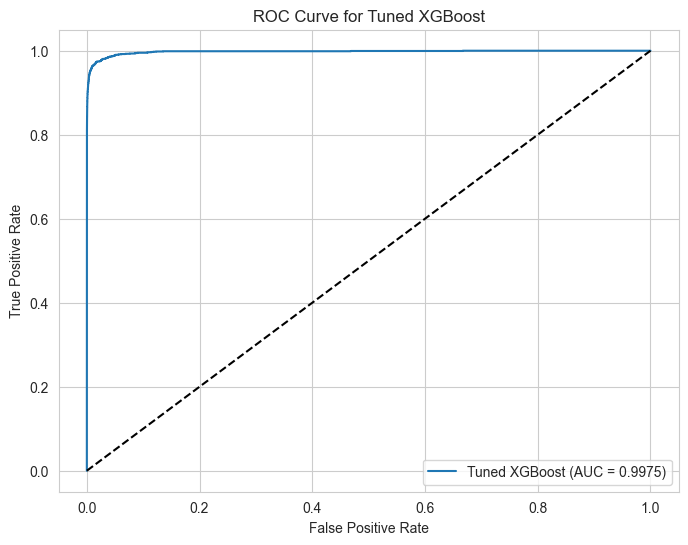

In [16]:
# Hyperparameter tuning for XGBoost (optimized)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Sample a subset of training data for tuning to reduce runtime
sample_size = min(100000, len(X_train))  # Use up to 100,000 samples
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train[sample_indices]
y_train_sample = y_train.iloc[sample_indices] if isinstance(y_train, pd.Series) else y_train[sample_indices]

# Apply SMOTE on sampled data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sample, y_train_sample)

# Simplified parameter grid
param_grid = {
    'n_estimators': [100, 150],  # Reduced range
    'max_depth': [3, 5],         # Reduced range
    'learning_rate': [0.1]       # Focus on effective value
}

# Use early stopping in XGBoost
xgb = XGBClassifier(random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled, eval_set=[(X_test, y_test)], verbose=False)

print("\nBest Parameters:", grid_search.best_params_)
tuned_model = grid_search.best_estimator_
y_pred = tuned_model.predict(X_test)
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]

print("\nTuned XGBoost Results:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc_tuned = auc(recall_tuned, precision_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba)
print(f"Precision-Recall AUC: {pr_auc_tuned:.4f}")
print(f"ROC AUC: {roc_auc_tuned:.4f}")
accuracy_tuned = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_tuned:.4f}")

# Plot ROC curve for tuned XGBoost
plt.figure(figsize=(8, 6))
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned XGBoost (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [17]:
# Real-time prediction pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', tuned_model)
])

# Example real-time transaction (optimized)
sample_transaction = {
    'step': 100,
    'type': 'TRANSFER',
    'amount': 250000,
    'nameOrig': 'C123',
    'oldbalanceOrg': 300000,
    'newbalanceOrig': 50000,
    'nameDest': 'C456',
    'oldbalanceDest': 100000,
    'newbalanceDest': 350000
}

# Process single transaction efficiently
df_single = pd.DataFrame([sample_transaction])
df_single['hour'] = df_single['step'] % 24
df_single['day'] = df_single['step'] // 24
df_single['is_night'] = ((df_single['hour'] >= 22) | (df_single['hour'] <= 5)).astype(int)
df_single['balance_diff_orig'] = df_single['oldbalanceOrg'] - df_single['newbalanceOrig']
df_single['balance_diff_dest'] = df_single['newbalanceDest'] - df_single['oldbalanceDest']
df_single['amount_to_balance_ratio'] = df_single['amount'] / (df_single['oldbalanceOrg'] + 1e-6)
df_single['is_merchant'] = df_single['nameDest'].str.startswith('M').astype(int)
df_single['type_encoded'] = le_type.transform([sample_transaction['type']])[0]
df_single['orig_txn_count'] = 1  # Single transaction

X_single = df_single[features]
prediction = pipeline.predict(X_single)[0]
probability = pipeline.predict_proba(X_single)[0][1]

print(f"\nReal-Time Prediction: {'Fraud' if prediction == 1 else 'Non-Fraud'}")
print(f"Fraud Probability: {probability:.4f}")


Real-Time Prediction: Non-Fraud
Fraud Probability: 0.0060


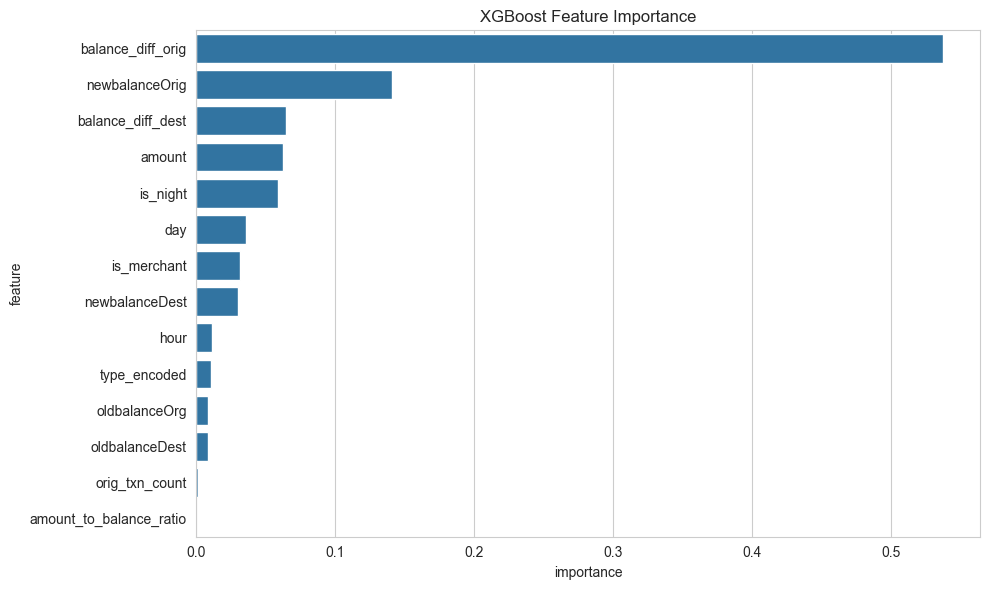

In [18]:
# Feature Importance for XGBoost
importance = pd.DataFrame({
    'feature': features,
    'importance': tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [19]:
# Save models and pipeline
joblib.dump(pipeline, 'fraud_detection_pipeline.pkl')
joblib.dump(le_type, 'type_encoder.pkl')
print("\nPipeline and encoder saved.")


Pipeline and encoder saved.
